# Fine tune YOLOv11

Fine tuning a YOLOv11 model to recognize new images and new categories. This notebook will outline a general implementation

The outcome is to:
- Get and save a pretrained YOLO checkpoint from huggingface hub
- Decompress and load a custom dataset
- Train/Fine-tune the model
- Test the new checkpoint
- Save the checkpoint for further use

We'll need a bunch of libraries:
- *pandas* in order to deal with structured annotation formats
- *pytorch* to deal with training functions and data types
- *ultralytics* to actually train the model

In [1]:
!pip list | awk '/torch|ultralytics|pandas/ {print $1}'

pandas
torch
torchvision
ultralytics
ultralytics-thop


In [2]:
# declare global setting variables 
YOLO_MODEL_PATH: str = "../model_checkpoints/Ultralytics/YOLO11/"
YOLO_MODEL_CHECKPOINT: str = "yolo11x.pt"
YOLO_MODEL_FILE: str = "yolo11x.yaml"
YOLO_ORIGINAL_MODEL: str = "/".join((YOLO_MODEL_PATH, YOLO_MODEL_CHECKPOINT))
TRAINING_DATASET_PATH: str = "/".join(("..", "datasets"))
DATASET_NAME: str = "mario"
DATASET_ARCHIVE: str = "mario-dataset.tar.gz"
CONFIG_FILE: str = "../parameters.yaml.local"

# setup ultralytics
from ultralytics import settings
settings.update({"datasets_dir": "."})

print(f"Using YOLO Model Original Checkpoint at: {YOLO_ORIGINAL_MODEL}")
print(f"Dataset '{DATASET_NAME}' will be loaded from {TRAINING_DATASET_PATH}")

Using YOLO Model Original Checkpoint at: ../model_checkpoints/Ultralytics/YOLO11//yolo11x.pt
Dataset 'mario' will be loaded from ../datasets


In [3]:
try:
    import os
    import torch
    from torch.utils.data import Dataset
    from torch import float16, float32
    import torch.cuda as tc
    import torch.backends.mps as apple_mps
    from pathlib import Path
    from torchvision.io import read_image
    import matplotlib.pyplot as plt
    from pandas import DataFrame, read_table
    import ultralytics
except Exception as e:
    print(f"Cannot load pytorch: {e}")

try:
    from libs.huggingface import pullFromHuggingfaceHub
    from libs.parameters import loadConfig, Parameters
except Exception as e:
    print(f"Cannot load custom python module: {e}")

# Decompress dataset

Decompress the data set tarball in the current directory for further use.

The dataset is composed of
- images/{train,validate} folders: where actual training images are stored for training and validation purposes
- labels/{train,validate} folders: where label annotations are stored, one txt file per source image
- task.yaml: the training task descriptor

In [4]:
# decompress tarball
def decompressDataset(datasetPath:str, destination: str) -> None:
    try:
        import tarfile as tf
    except Exception as e:
        raise e

    # check destination path
    if not os.path.isdir(destination):
        print(f"Creating destination dir {destination}...")
        os.mkdir(destination)

    # decompress file
    with tf.open(datasetPath) as dset_file:
        for f in dset_file.getnames():
            if not os.path.exists("/".join((destination,f))):
                print(f"Extracting {f}...")
                dset_file.extract(f, destination)

# Load the training dataset and explore it

Now we define a custom Dataset class that will hold our training and validation data.
The custom class scans the dataset path for images and annotation files and organizes them in a data structure

The dataset class is then iterable and returns a data point tuple:
- a *torch.Tensor* object holding the image pixel data
- a *pandas.DataFrame* object holding the label annotations for that specific image


In [5]:
# create a new dataset class that holds training data information
class CustomDataset(Dataset):
    def __init__(self, path: str, step: str = "train") -> None:
        self.image_datapath: Path = Path(path + "/images" + f"/{step}")
        self.labels_datapath: Path = Path(path + "/labels" + f"/{step}")
        
        # load objects
        self.imgs: list = [f for f in self.image_datapath.glob("**/*.jpg")]
        self.labels: list = [f for f in self.labels_datapath.glob("**/*.txt")]

        # validate
        for fname in self.imgs:
            img_id = fname.stem
            labelname = self.labels_datapath / f"{img_id}.txt"
            if labelname not in self.labels:
                raise Exception(f"Missing labels file for image id {img_id}")

    def __len__(self) -> int:
        return len(self.imgs)

    def __getitem__(self, idx) -> (torch.Tensor, DataFrame):
        # get image at index 'idx'
        image: torch.Tensor = read_image(self.imgs[idx])
        # load related annotations
        labels: DataFrame = read_table(self.labels_datapath / f"{self.imgs[idx].stem}.txt",
                                      sep=" ",
                                      header=None)

        # return datapoint
        return (image, labels)

# load labels and ids
def loadLabels(descriptorFile: str) -> dict:
    import yaml
    try:
        with open(descriptorFile) as yf:
            descriptor_contents = yaml.safe_load(yf)
    except Exception as e:
        print(f"Caught YAML Exception: {e}")

    return descriptor_contents.get("names")

In [6]:
# datapoint visualization
def plotDataPoint(img_rgb: torch.Tensor, annotations: DataFrame, labels: dict) -> None:
    """
        plot an image with its relative object bounding boxes in overlay
    """
    # permute channels and get image sizes
    img = img_rgb.permute(1,2,0)
    img_h, img_w, channels = img.shape

    # plot image
    plt.title(f"Dataset Point: {len(annotations)} objects")
    plt.imshow(img)

    # calculate bounding boxes
    axes = plt.gca()
    for annotation in range(len(annotations)):
        label, center_x, center_y, bounding_w, bounding_h = annotations.loc[annotation, :].values.flatten().tolist()
        print(f"Bounding Box: {label}, {center_x}, {center_y}, {bounding_w}, {bounding_h}")

        # scale coordinates - BOX CENTER
        cx, cy = center_x * img_w, center_y * img_h
        # scale coordinates - BOX DIMENSIONS
        bw, bh = (bounding_w * img_w), (bounding_h * img_h)

        # add bounding box
        from matplotlib.patches import Rectangle
        axes.add_patch(Rectangle((cx - bw/2, cy - bh/2), bw, bh, color="white", fill=None))
        # add label
        ltext = labels.get(label)
        lpos = (cx - bw/2, cy - bh/2 - 10)
        axes.text(lpos[0], lpos[1], ltext, color="white", fontsize=12)

    # show datapoint
    plt.show()

# Dataset test

A datapoint is a tuple containing:
- A torch.Tensor
- A pandas DataFrame

The tensor represents the image. Its shape is by default in the format (C,H,W):
- C: number of channels
- H: image height
- W: image width

To plot the image with pyplot we need to permute channels from (C,H,W) to (H,W,C)

The Dataframe holds information about labels, in the format that is needed by the Ultralytics libs to train the YOLO model.
The file is structured like this:

- One bounding box per row
- Each Row contains:
  - The Label Class (int)
  - The coordinates of the center of the bounding box (float) relative to the image size
  - The sizes of the bounding box relative to the image size and the bounding box center (float)

Extracting mario...
Extracting mario/._classes.txt...
Extracting mario/classes.txt...
Extracting mario/._test...
Extracting mario/test...
Extracting mario/._mario-dataset.tar.gz...
Extracting mario/mario-dataset.tar.gz...
Extracting mario/._images...
Extracting mario/images...
Extracting mario/._labels...
Extracting mario/labels...
Extracting mario/._notes.json...
Extracting mario/notes.json...
Extracting mario/._mario.yaml...
Extracting mario/mario.yaml...
Extracting mario/labels/._validate...
Extracting mario/labels/validate...
Extracting mario/labels/._train...
Extracting mario/labels/train...
Extracting mario/labels/train/._5bfd0f4a-yoschi-1557253_640.txt...
Extracting mario/labels/train/5bfd0f4a-yoschi-1557253_640.txt...
Extracting mario/labels/train/._290e218a-mario-1557973_640.txt...
Extracting mario/labels/train/290e218a-mario-1557973_640.txt...
Extracting mario/labels/train/._35af73b0-mario-1557975_640.txt...
Extracting mario/labels/train/35af73b0-mario-1557975_640.txt...
Extr

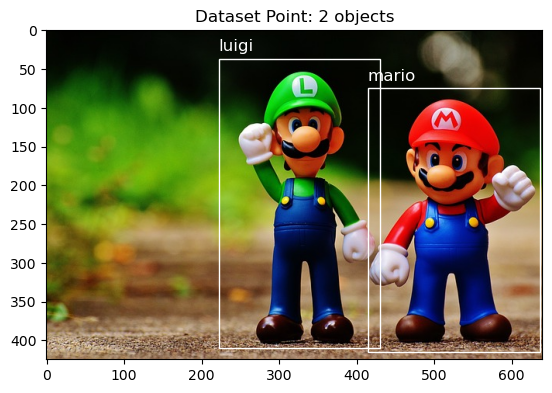

In [7]:
# dataset file path
ds_file_path: str = "/".join((TRAINING_DATASET_PATH, DATASET_ARCHIVE))
ds_target_path: str = "."
dataset_path: str = ds_target_path + "/mario"
ds_descriptor_file: str = ds_target_path + "/mario/mario.yaml"

# decompress dataset in the target directory
try:
    decompressDataset(ds_file_path, ds_target_path)
except Exception as e:
    print(f"Caught exception: {e}")

# load dataset
training_dataset = CustomDataset(dataset_path, step="train")
validation_dataset = CustomDataset(dataset_path, step="validate")
print(f"Training Dataset loaded, contains {len(training_dataset)} images.")
print(f"Validation Dataset loaded, contains {len(validation_dataset)} images.")

# load labels
label_dict: dict = loadLabels(ds_descriptor_file)

# get a data point from data set
try:
    datapoint: tuple = training_dataset[0]
    
    # image from dataset
    img: torch.Tensor = datapoint[0]
    
    # datapoint annotations
    annotations: DataFrame = datapoint[1]

    # plot datapoint
    plotDataPoint(img, annotations, label_dict)
except Exception as e:
    print(f"Caught exception: {e}")

# Hardware detection

Now we proceed to determine which hardware we can use for training the model.
Currently (and based on what pytorch supports), these backends are autodetected:

- Plain CPU, no acceleration
- Apple Metal Performance Shaders (mps)
- Nvidia CUDA (or any accelerator labelled as 'cuda' by pytorch)

In [8]:
# detect accelerator
def detectAccelerator() -> (str, torch.dtype):
    accelerator = "cpu"
    dtype = float32
    
    # ensure the apple mps backend is loaded and hardware initialized
    if apple_mps.is_available():
        print("Apple Metal Performance Shaders Available")
        accelerator = "mps"
        dtype = float16
    # check for cuda
    elif tc.is_available():
        print("CUDA Accelerator Available")
        accelerator = "cuda"
        dtype = float16
        !nvidia-smi

    # return
    return (accelerator, dtype)

In [9]:
# load parameters from config file
import yaml
try:
    parms = loadConfig(CONFIG_FILE)
except yaml.YAMLError as e:
    print(f"Error while loading config parameters {e}")

# Download the pretrained YOLO checkpoint we want to finetune

If the checkpoint is not already present on the filesystem, pull it from huggingface
Then load the pretrained weights and move the model to the selected accelerator.

In [10]:
# Training Parameters
JOB = "detect"
RUN_NAME = "train"
CHECKPOINT = "last.pt"
EPOCHS = 20
LR = 1e-4
IMG_SIZE = 640
BATCH = 2
OPTIMIZER = "AdamW"
AUGMENT = True

In [11]:
# detect accelerator
accelerator, dtype = detectAccelerator()

# make sure the checkpoint is on the filesystem
latest_checkpoint: str = f"runs/{JOB}/{RUN_NAME}/weights/{CHECKPOINT}"
if os.path.exists(latest_checkpoint):
    print(f"Loading checkpoint {latest_checkpoint}...")
    yolo_model = ultralytics.YOLO(YOLO_MODEL_FILE).load(latest_checkpoint)
    yolo_model.to(accelerator)
    resume = True
else:
    if not os.path.exists(YOLO_ORIGINAL_MODEL):
        print(f"Downloading model from huggingface... {YOLO_ORIGINAL_MODEL}")
        pullFromHuggingfaceHub(parms)
    # start from scratch
    print(f"Loading checkpoint {YOLO_ORIGINAL_MODEL}...")
    yolo_model = ultralytics.YOLO(YOLO_MODEL_FILE).load(YOLO_ORIGINAL_MODEL)
    yolo_model.to(accelerator)
    resume = False

Apple Metal Performance Shaders Available
Loading checkpoint ../model_checkpoints/Ultralytics/YOLO11//yolo11x.pt...
Transferred 1015/1015 items from pretrained weights


In [12]:
# start training!
yolo_model.train(data="./mario/mario.yaml",
                 epochs=EPOCHS, lr0=LR, imgsz=IMG_SIZE, batch=BATCH,
                 resume=resume, optimizer=OPTIMIZER, augment=AUGMENT
                )

New https://pypi.org/project/ultralytics/8.3.100 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolo11x.yaml, data=./mario/mario.yaml, epochs=20, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=mps:0, workers=8, project=None, name=train, exist_ok=False, pretrained=../model_checkpoints/Ultralytics/YOLO11//yolo11x.pt, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

train: Scanning /Users/mcaimi/Work/Sources/pycamera/jupyter/mario/labels/train... 11 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11/11 [00:00<00:00, 2499.99it/s]

train: New cache created: /Users/mcaimi/Work/Sources/pycamera/jupyter/mario/labels/train.cache



val: Scanning /Users/mcaimi/Work/Sources/pycamera/jupyter/mario/labels/validate... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 1864.14it/s]

val: New cache created: /Users/mcaimi/Work/Sources/pycamera/jupyter/mario/labels/validate.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.81G      1.088      3.172      1.646          5        640: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all          2          3     0.0173          1       0.31      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.97G      1.148      2.726      1.654          4        640: 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all          2          3      0.403      0.333      0.475      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.97G      1.222      2.255      1.647          4        640: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          2          3      0.908      0.333      0.673      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.97G      1.062       2.02      1.506          7        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all          2          3      0.908      0.333      0.673      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.97G     0.9224      1.519      1.335          6        640: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          2          3      0.653      0.667      0.774      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.97G      1.003      1.624      1.484          2        640: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          2          3      0.653      0.667      0.774      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.97G      1.049      1.532      1.594          2        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          2          3      0.919      0.667      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.97G      1.124       2.01      1.701          4        640: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all          2          3      0.919      0.667      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.97G      1.091      1.648       1.52          4        640: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          2          3      0.955      0.667      0.829      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.97G     0.8405       1.24      1.327          2        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all          2          3      0.955      0.667      0.829      0.685


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.97G     0.8355      1.292      1.283          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          2          3      0.955      0.667      0.829      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.97G     0.8751       1.39      1.486          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all          2          3      0.955      0.667      0.829      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.97G     0.8039      1.333      1.427          2        640: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all          2          3      0.955      0.667      0.829      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.97G     0.6438      1.287      1.101          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          2          3      0.622          1      0.829      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.97G     0.7195      1.278      1.367          2        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all          2          3      0.622          1      0.829      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.97G      0.699      1.378      1.211          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all          2          3      0.622          1      0.829      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.97G      0.865      1.749       1.52          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          2          3      0.622          1      0.829      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.97G     0.7733       1.19      1.243          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all          2          3      0.622          1      0.829      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.97G     0.5983      1.257      1.141          2        640: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          2          3      0.622          1      0.829      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.97G      0.855      1.292      1.524          2        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          2          3      0.622          1      0.829      0.708



20 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 114.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.12.3 torch-2.5.1 MPS (Apple M1 Pro)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


                   all          2          3      0.581      0.975      0.829      0.746
                 luigi          1          1      0.676          1      0.995      0.995
                 mario          1          1      0.462      0.925      0.497      0.348
                 yoshi          1          1      0.604          1      0.995      0.895
Speed: 1.0ms preprocess, 1640.8ms inference, 0.0ms loss, 207.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x361b6f410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# Training Review

At this step, the model has been finetuned and we can measure the outcomes: look into the training run folder for detailed graphs and information

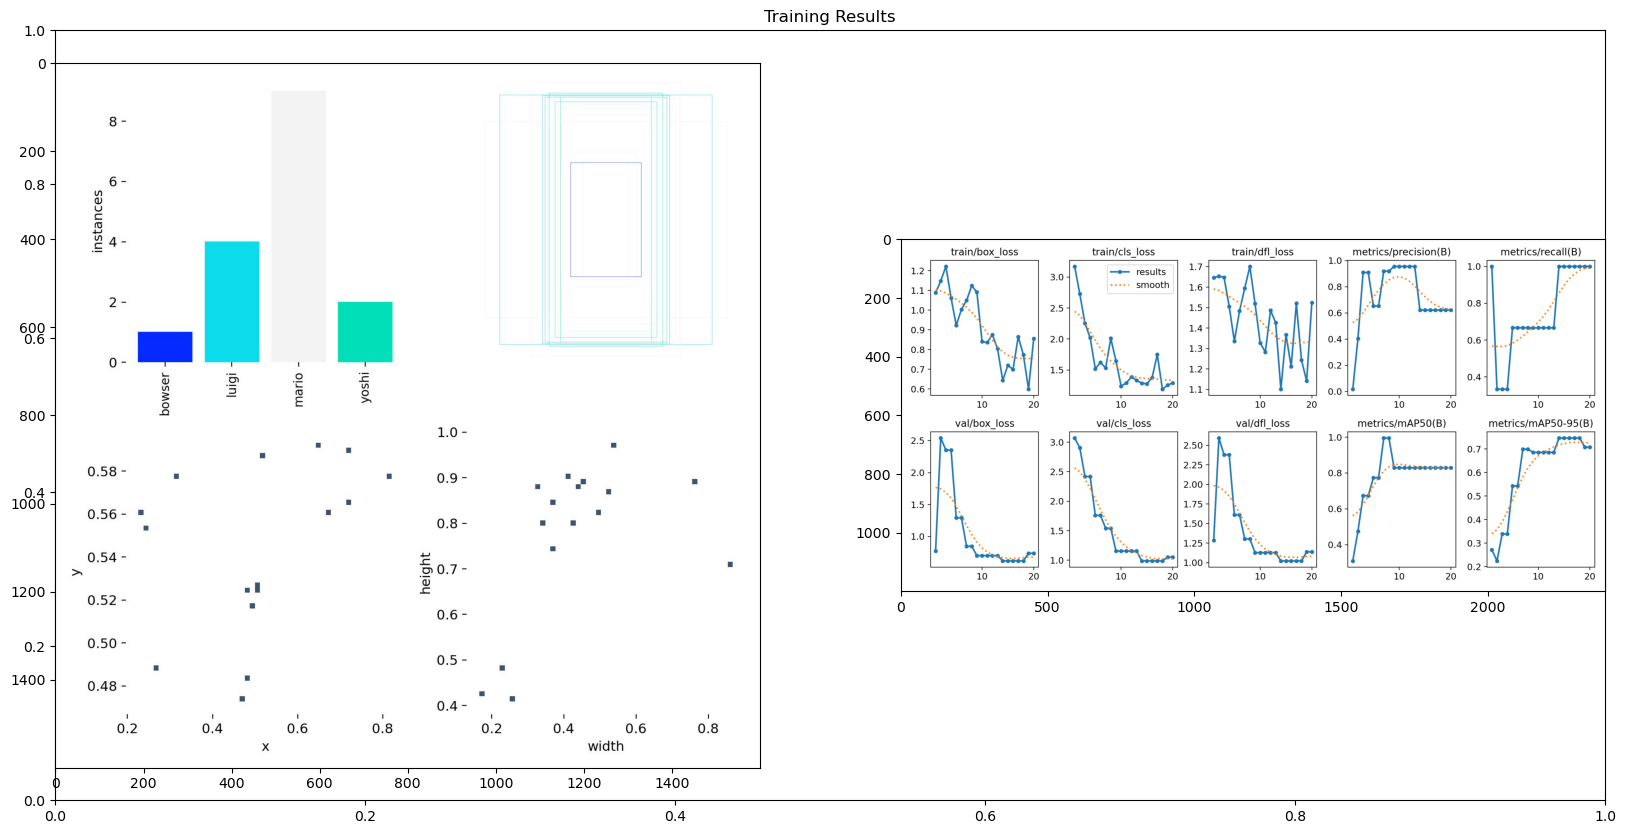

In [13]:
# load results
results_path: str = f"runs/{JOB}/{RUN_NAME}/"

# print graphs
plt.figure(figsize=(20,10))
plt.title("Training Results")
plt.subplot(121)
plt.imshow(read_image(results_path + "labels.jpg").permute(1,2,0))
plt.subplot(122)
plt.imshow(read_image(results_path + "results.png").permute(1,2,0))

In [15]:
# analyze detected features
def detectedObjects(inferenceOutput):
    for o in inferenceOutput:
        object_classes = o.names
        for obj in o.boxes:
            if type(obj.xyxy) is torch.Tensor:
                # determine object coordinates
                bbox = obj.xyxy.cpu().type(torch.int32).numpy()
                x1, y1, x2, y2 = bbox[0]

                # determine object classification label and confidence score
                class_label = object_classes[int(obj.cls)]
                confidence = float(obj.conf)
                # print detected object class
                print(f"{class_label} - {confidence:.2f}")

# Test Inference
prediction = yolo_model(dataset_path + "/test/mario_test.png")


image 1/1 /Users/mcaimi/Work/Sources/pycamera/jupyter/mario/test/mario_test.png: 448x640 1 mario, 2729.7ms
Speed: 11.8ms preprocess, 2729.7ms inference, 223.3ms postprocess per image at shape (1, 3, 448, 640)


In [16]:
detectedObjects(prediction)

mario - 0.84


# Save finetuned model and cleanup

In [17]:
# convert checkpoint?
CONVERT_ONNX = True
if CONVERT_ONNX:
    yolo_model.export(format="onnx")

# export model to data path
import shutil
shutil.copy(latest_checkpoint, YOLO_MODEL_PATH)

Ultralytics 8.3.91 🚀 Python-3.12.3 torch-2.5.1 CPU (Apple M1 Pro)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (109.1 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.49...
ONNX: export success ✅ 2.8s, saved as 'runs/detect/train/weights/best.onnx' (217.1 MB)

Export complete (3.6s)
Results saved to /Users/mcaimi/Work/Sources/pycamera/jupyter/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=./mario/mario.yaml  
Visualize:       https://netron.app


'../model_checkpoints/Ultralytics/YOLO11/last.pt'